# Assignment 2: “Text Mining with Simpsons ”
Due: Monday 2pm, December 14, 2020, via Moodle

### Submission guidelines

- Solutions need to be uploaded as a single Jupyter notebook. You will find many provided codes in the notebook, your task is to fill in the missing cells.
- For the written solution use LaTeX in markdown inside the same notebook. Do *not* hand in a seperate file for it.
- Download the .zip file containing the dataset but do *not* upload it with your solution.
- It is sufficient if one person per group uploads the solution to Moodle, but make sure that the names of
all team members are given on the PDF and in the source code.

--------

The Simpson show is the world’s longest-running animated sitcom. The show revolves around the lives of the Simpson family, which consists of Homer, Marge, Bart, Lisa, and the little Maggi.
For this notebook, you should download the dataset that contains the characters, locations, episode details, and script lines for approximately 600 Simpsons episodes, dating back to 1989.
In the following exercises, we will explore the data and use visualizations to gain some insight into the show. The Zip file alongside this notebook should contain the following files:

` simpsons_characters.csv, simpsons_locations.csv, simpsons_script_lines.csv, simpsons_episodes.csv`


Take some time and familiarize yourself with the data. `simpsons_characters.csv` contains the character-names and their gender.
`simpsons_locations.csv` contains information about locations in the shows,
and `simpsons_episodes.csv` has information about each episode including their title, rating, and views.
Finally, `simpsons_script_lines.csv` lists all the lines in the show, who said the line and where it was said. Be aware that this data set is not cleaned and, hence, includes faulty data as well as inconsistent data types.

Import the needed packages:

In [90]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from os import path
import time
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#nltk.download('cmudict')
from nltk.corpus import cmudict
%matplotlib inline

Let's read the data and get started!

### Task 1:  Important Characters (3 + 2 + 2 + 4 = 11 point)
### Sub-Task 1: 
Load the four datasets in the respective variables using pandas (pd),
make sure to set the type of the `character_id` to integer and drop the line that has the non-numeric character ID `142024`.

In [3]:
df_characters = pd.read_csv('data/simpsons_characters.csv')
df_locations = pd.read_csv('data/simpsons_locations.csv')
df_script = pd.read_csv('data/simpsons_script_lines.csv')
df_episodes = pd.read_csv('data/simpsons_episodes.csv')

/home/erik/disk/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Using panda's `.head()` function look at the top rows of each dataset.

In [3]:
df_characters.head(2)

,id,name,normalized_name,gender
0,7,Children,children,NaN
1,12,Mechanical Santa,mechanical santa,NaN


In [4]:
df_locations.head(2)

,id,name,normalized_name
0,1,Street,street
1,2,Car,car


In [5]:
df_script.head(2)

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3


In [6]:
df_episodes.head(2)

,id,image_url,imdb_rating,imdb_votes,number_in_season,number_in_series,original_air_date,original_air_year,production_code,season,title,us_viewers_in_millions,video_url,views
0,10,http://static-media.fxx.com/img/FX_Networks_-_...,7.4,1511.0,10,10,1990-03-25,1990,7G10,1,Homer's Night Out,30.3,http://www.simpsonsworld.com/video/275197507879,50816.0
1,12,http://static-media.fxx.com/img/FX_Networks_-_...,8.3,1716.0,12,12,1990-04-29,1990,7G12,1,Krusty Gets Busted,30.4,http://www.simpsonsworld.com/video/288019523914,62561.0


Let's take a look at the important characters of the show. To start we detect the main characters by the number of spoken words/lines throughout the show. 
Extract top 10 characters based on the number of spoken words (word count) as well as the 10 most prominent characters regarding the number of lines they head during the show.

Compare both results by drawing two bar plots: For the first plot, the x-axis should show the name of the top 10 characters with regard to the word count and the y-axis should display the number of spoken words.
In the second plot, you should do the same but this time considering the number of lines for each character (,i.e., the characters displayed on the x-axis can be different for the first and second bar plot). You might notice that there is a column with `word_count` in the `scripts` data frame, but cleaning it up might be tricky. To find the sum of all values, first remove the `nan` and any other string characters in that colum, you can use the `conv` function provided.

In [88]:
# def conv(row):
#     try:
#         return int(row)
#     except:
#         return np.nan

In [89]:
# start = time.time()
# df_script['word_count'] = df_script['word_count'].apply(conv)
# stop = time.time()
# print(stop-start) #: 0.08487224578857422

0.0894167423248291


In [78]:
start = time.time()
df_script["word_count"] = pd.to_numeric(df_script['word_count'], errors='coerce')
stop = time.time()
print(stop-start)

0.07593202590942383


In [94]:
# there are extreme outliers
df_script.loc[df_script['raw_character_text']=='Robert Pinsky','word_count']

73531        17
73535        18
73536        33
73537    672000
73546        51
73548         7
Name: word_count, dtype: object

In [90]:
top_characters_words = df_script[['raw_character_text','word_count']]
top_characters_words = top_characters_words.dropna()
merge_data_words_sub = top_characters_words.groupby('raw_character_text')['word_count']\
                            .sum()\
                            .sort_values(ascending=False)\
                            .iloc[:10].astype(int)
merge_data_words_sub.head(5)

raw_character_text
Marge Simpson    1269710
Entire Town      1154000
Homer Simpson     680208
Robert Pinsky     672126
ABBA              571000
Name: word_count, dtype: int64

#### Top characters by number of lines
lines of a character = rows belonging to a specific 

In [35]:
top_characters_sentences = df_script[['raw_character_text','spoken_words']]
# dropping na/('' which by default is read as na) to assure that nans in the spoken words are not counted 
top_characters_sentences = top_characters_sentences.dropna()
merge_data_sentences_sub = top_characters_sentences.groupby('raw_character_text')['spoken_words']\
                            .count()\
                            .sort_values(ascending=False)\
                            .iloc[:10]
merge_data_sentences_sub.head(10)

raw_character_text
Homer Simpson          27912
Marge Simpson          13193
Bart Simpson           13013
Lisa Simpson           10769
C. Montgomery Burns     3087
Moe Szyslak             2810
Seymour Skinner         2390
Ned Flanders            2057
Grampa Simpson          1807
Chief Wiggum            1796
Name: spoken_words, dtype: int64

In [ ]:
#### Draw the word count plot ####
#### Hint: look at the plot function from dataframe #### 

<AxesSubplot:xlabel='raw_character_text'>

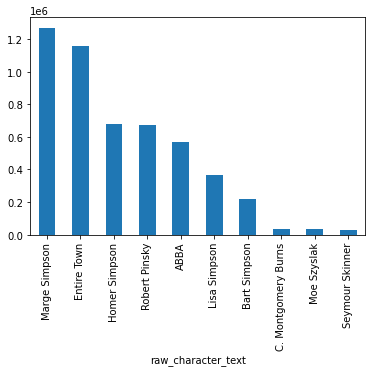

In [82]:
merge_data_words_sub.plot(kind = 'bar')

<AxesSubplot:xlabel='raw_character_text'>

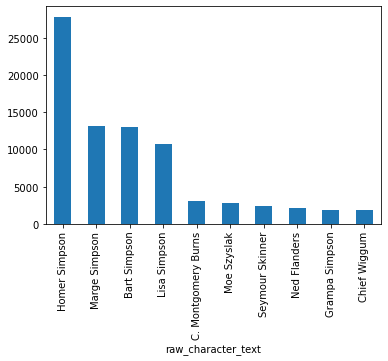

In [81]:
merge_data_sentences_sub.plot(kind = 'bar')

In [ ]:
#### Draw the sentence count plot ####
#### Hint: look at the plot function from dataframe #### 

If you have done the exercise correctly you should see that the top-4 characters of the show (Homer, Marge, Bart, and Lisa Simpson) have the most dialogs (lines) in the show but their distribution differs when we look at the word count.
Seems like some characters speak in long sentences.

### Sub-Task 2: Common Words and Word Cloud 
Let's examine the dialogues and look at the top 20 common words, draw a bar plot in the same way as above to show the frequencies.
To generate a meaningful output use the preprocessing pipelines explained in the lecture: 
- use regex to remove non-alphabetic characters and also remove `'` since the tokenizer will treat it as a new token (anything that is not a number or alphabet including punctuations)
- lowercase all words
- remove stopwords based on spaCy's stopword list
- tokenize the `spoken_words` (remove single characters produced by the tokenizer)
- perform stemming 
 
In this exercise, we require you to use SpaCy for all language processing steps except for stemming.
This is due to the lack of a stemmer in SpaCy's library that only provides a tool for lemmatization.
Hence, for Stemming we are going to use one of the stemmers provided by NLTK.


In [4]:
import spacy 
import re 
from collections import Counter
from matplotlib import pyplot as plt
from nltk.stem import PorterStemmer

In [ ]:
nlp = spacy.### load en_core_web_sm and disable the tagger, parser and ner.
stopwords = ### load the list of stopwords from spacy for the English language
stemmer = ### initialize the stemmer from NLTK

df_script["spoken_words"] = df_script["spoken_words"]. ### Your code to lower case and remove non-alphabetic characters

In [ ]:
counter = Counter()
#### Count the words in the scripts and print out the most common 20, remove any single character tokens and stem

In [ ]:
#### draw a bar plot with the x axis as the words and the y axis as the frequencys

Generate a word cloud to visualize the frequencies:
A word cloud is a graphical representation of frequently used words in the normalized text.
The height of each word in this picture is an indication of the frequency of occurrence of the word in the entire text.
You will need to install the package `wordcloud`.
To achieve a homogeneous output, set the `max_words` to 100 and `max_font_size` to 60.
Make sure the same word does not appear more than once.

In [39]:
from wordcloud import WordCloud

In [ ]:
wordcloud = WordCloud( 
    #### your code ####
)
    
fig = plt.figure(1, figsize=(12, 12))
plt.axes("off")
plt.imshow(wordcloud, interpolation="bilinear")

### Sub-Task 3: Common Named Entities 
Apply named entity recognition using SpaCy and generate a word cloud of the top 50
named entities that have the type `PERSON`, using the same approach
for visualization as above. Take into account that you cannot simply use the
output of the previous step and need to undo the stemming. Since the named entity
recognition takes quite some time, use only the first `10000` scripts.

In [22]:
spoken_words = df_script.spoken_words.dropna().iloc[:10000]

In [5]:
nlp = spacy.load("en_core_web_sm")

In [18]:
from collections import defaultdict

In [27]:
pos_tags_list = defaultdict(list)

In [30]:
for spoken_word in spoken_words.values:
    for word in nlp(spoken_word):
        pos_tag = word.ent_type_
        word_text = word.text
        pos_tags_list[pos_tag].append(word_text)


In [44]:
pos_tags_counts = Counter(pos_tags_list['PERSON'])

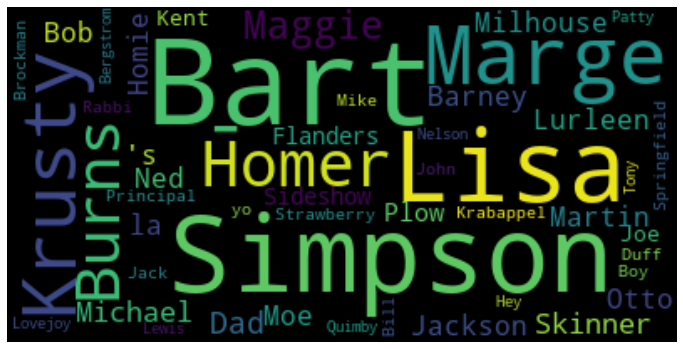

In [46]:
fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(WordCloud(max_words=50, ).generate_from_frequencies(pos_tags_counts), interpolation="bilinear")

How well does the named entity recognition work? Do you notice some strange "people" in there?

### Sub Task 4 : Sophistication of Speech
 

Take into account the top 10 characters from the first subtask (based on line count), it is interesting to see whether there are big differences in the sophistication of speech or vocabulary size between the characters.
To measure this, we turn to the Flesch Reading Ease. Although designed for written text we use it here on spoken words.
This measures indicates how difficult a passage in English is to understand and is based on a ranking scale of 0-100, where higher scores indicate material that is easier to read; lower numbers mark passages that are more difficult to read.
For more information look at the [wiki page](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests).

$206.835 - 1.015 \times \frac{total words}{total sentences} - 84.6 \times \frac{total syllables}{total words}$

For syllable counts, download `cmudict` from the NLTK library and count the vowel sounds from the Carnegie Mellon Pronouncing Dictionary (cmudict).
Then count vowel sounds in each word, if a word is not in the dictionary do not count it in.
CMUdict marks each vowel with a stress tag, 0 (unstressed), 1 (stressed), or 2 (secondary stress).

In [ ]:

phoneme_dict = dict(cmudict.entries())
nlp = # load the same spacy model again, with tagger, parser and ner disabled.
nlp.add_pipe(nlp.create_pipe('sentencizer'))

def syllable_counter(word):
    ### functionn that counts a syllable in a word 

def total_sylls(x): 
    ### function to use with apply method, to count the total number of syllable in line of a script 
    
def sentence_count(x):
    ### function to use with apply method, to count the total number of sentences in line of a script 

df_script['syllable_count'] =
df_script['sentence_count'] = 
top_characters_counts = ## use aggragations to find the word_count, syllable_count and sentence_count per person 
top_characters_counts['Flesch_readability'] =
merge_data_words_sub = ### merge with df_characters to find the character nanmes 
### draw plot 

## Task 2: TF-IDF ( 3 + 4 = 7 points)


## Sub Task 1: 
Despite all the preprocessing, so far the top words we looked at are not so informative.
We wish to find out the important words that are spoken by the top characters.
For example, the youngest of the family should have "mom" as an important word.
We looked at the Term Frequency - Inverse Document Frequency (TF-IDF) weighting in the lecture, so let's use that here to detect the most important words per character.
In this case, each script line is a document for a certain character who spoke the words.
Use `CountVectorizer` and `TfidfTransformers` from scikit-learn, and use the scikit-learn stop word list to remove stop words and remove the words with a frequency less than 5 from the analysis.
Then plot the TF-IDF values for the top 10 words for Homer, Marge, Bart, and Lisa Simpson as a bar plot.

In [ ]:

del df_script['id']
df_script = df_script.rename(columns = {'character_id':'id'})  # to merge easily

In [ ]:
merged_data = #merge the dataframes to the characters to get the names and drop nan values

for name in ['Homer Simpson', 'Marge Simpson', 'Bart Simpson', 'Lisa Simpson']:
    ##### Your code ######
    count_vectorized =
    transformer = 
    ### Don't forget that you need the tfidf values for a single word averaged across documents ####

If you did the exercise correctly, "mom" and "dad" should be among the top words for the childern and "homer" should be the top word for Marge, since this is what she calls her husband.

## Sub Task 2: 
If we consider the spoken words from each character a document of its own, we can generate 4 documents (by concatenation of all dialogs) for Homer, Marge, Bart, and Lisa Simpson, and create document vectors from those.
Let's take a look at how the values in these vectors are distributed. Use  `sns.heatmap` from the seaborn package to show the vectors of the 4 documents for the top-20 words (set the `max_features` parameter of the `CountVectorizer` to 20).
Compare it with the heatmap of only term frequencies of the documents. Use `fmt='g'` to print out the correct format.

In [ ]:
import seaborn as sns

In [ ]:
fig, ax = plt.subplots(figsize=(17,6))         
sns.heatmap(### Your tfidf weights ###
    , annot=True, cbar=False, ax=ax, xticklabels=# top 20 words
)

In [ ]:
fig, ax = plt.subplots(figsize=(17,6))         
sns.heatmap(### Your count vectorizer weights ###
    , annot=True, cbar=False, ax=ax, xticklabels=#top 20 words
)

Based on the TF_IDF vectors of the top-20 words, which characters are similar?

In [ ]:
from sklearn.metrics import pairwise
names = ['Homer Simpson', 'Marge Simpson', 'Bart Simpson', 'Lisa Simpson']
cosine= ### Your code ### 
for i,name in zip(range(4),names):
    for j,name2 in zip(range(i+1,4),names[i+1:]):
        print('{} to {}: {}'.format(name, name2, ### Your code to compute cosine similarity ###))


# Task 3: Topics ( 4 + 3 = 7 points)

It is interesting to inspect the topics often discussed in the show. We look at SVD (LSA) and NMF for topic detection.

## Sub Task1:
Use `NMF` from scikit-learn to detect topics in the scripts, and use the text cleaning steps from the first task:
- use regex to remove non-alphabetic characters and also remove `'` since the tokenizer will treat it as a new token (anything that is not a number or alphabet including punctuations)
- lowercase all words
- remove stopwords based on spaCy's stopword list for English
- tokenize the spoken_words (remove single characters produced by the tokenizer) 
- perform stemming 

set the `max_features` of  `CountVectorizer` to 10,000 and `random_state` of the `NMF` to 42, `n_components=10`.

In [78]:
stopwords = nlp.Defaults.stop_words

In [81]:
corpus = []
tokenizer = nltk.tokenize.TreebankWordTokenizer()
stemmer = PorterStemmer()
def preprocess(line):
    
    try:    
        preprocessed = [stemmer.stem(word) for word in tokenizer.tokenize(re.sub("[^a-zA-Z\s]",'',line).lower()) \
                        if (word not in stopwords) and len(word)!=1  ]
        if len(preprocessed)!=0:

            return ' '.join(preprocessed)
        else:
            return np.nan
    except:
        return np.nan

In [48]:
from sklearn.decomposition import NMF 


In [108]:
def show_topics(components, num_top_words, vocab):
    #for each component or topic sorts the row values from large to small and returns the top words and the representation of the topic.
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in components])
    return [' '.join(t) for t in topic_words]

In [82]:

df_script.dropna(inplace=True)
df_script.spoken_words = df_script.spoken_words.apply(preprocess)

In [91]:
vectorizer = CountVectorizer(max_features = 10000)

In [95]:
vectorized = vectorizer.fit_transform(df_script.spoken_words.dropna())

In [92]:
nmf = NMF(n_components=10, random_state=42)

In [100]:
documents_topics = nmf.fit_transform(vectorized)

In [116]:
terms_topics = nmf.components_

Use the `show_topics()` method to show the top-20 words for the top 2 topics.

In [125]:
show_topics(terms_topics[:2],20, vectorizer.get_feature_names())

['im sorri go sure afraid think cant man look marg tri tell glad kid gon time love way good ive',
 'oh yeah god man thank boy good cant love ye uh marg come look wait littl great sorri dear day']

## Sub Task 2:
The SVD algorithm factorizes a matrix into one matrix with orthogonal columns and one with orthogonal rows (along with a diagonal matrix, which contains the relative importance of each factor).
Latent Semantic Analysis (LSA) uses SVD. Here we use the 'TruncatedSVD' method from 'sklearn' to look at the topics.
This is faster than SVD since we focus only on the largest singluar values.
Use the cleaned documents form the substask before. Where `random_state=42`, `n_components=10`, and `n_iter=7`.

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
svd = TruncatedSVD(#### Your Code ####)

Use the `show_topics` method to show the top-20 words for the top-2 topics. 

In [ ]:
show_topics(#### Your Code ####)

As you can see there is not much to make out of these topics. But topic models also give us document representations, so let's compare Homer, Marge, Bart, and Lisa Simpson based on their SVD vectors.
Use the same approach as the TF_IDF Task, but apply the pre-processing steps mentioned in the previous subtask.
Notice that if you use the default parameters for the SVD you might encounter a strange shape in the transformed data.
This happens because the underlying algorithm is set to 'randomized_svd'.
Investigate how to solve this problem and run the algorithm with `n_components=2, n_iter=7, random_state=40`.
Hint: You need one extra parameter to overcome this problem.
Transform the TF_IDF vectors for the 4 subsets to the SVD and compute the cosine similarity.

In [ ]:
subsets = {}
for name in ['Homer Simpson', 'Marge Simpson', 'Bart Simpson', 'Lisa Simpson']:
    subsets[name] = merged_data[merged_data['name']==name]['normalized_text'].### Your code ###

In [ ]:
count_vectorized = CountVectorizer(analyzer='word', max_features=10000)
### Your Code ### 
svd = ### Your Code ###
svd.fit(### Your Code ### 
new_weights = ### Your Code ###

In [ ]:
names = ['Homer Simpson', 'Marge Simpson', 'Bart Simpson', 'Lisa Simpson']
cosine = ###Compute the cosine similirity###
for i, name in zip(range(4),names):
    for j, name2 in zip(range(i+1,4),names[i+1:]):
        print('{} to {}: {}'.
                  format(name,name2,###Cosine Similiarity### ))

## Task 4: Mathematical Concepts ( 1 + 2 + 2 = 5 points)
Answer the following questions in the notebook, use markdown or latex to fill in the cells for the answers:

## Sub Task 1: 
What is the relationship between PCA and SVD? 

## Sub Task 2: 

Find the Singular value decomposition of  $A = \left[ \begin{matrix}1&-1\\ -2&2\\ 2&-2\end{matrix} \right]$.


## Sub Task 3:

Consider the term-document matrix 

|        | d1 | d2 | d3 | d4 | d5 | d6 |
|--------|----|----|----|----|----|----|
| bank   | 1  | 2  | 1  | 2  | 1  | 1  |
| money  | 0  | 0  | 0  | 2  | 1  | 2  |
| river  | 2  | 0  | 2  | 0  | 0  | 0  |
| ship   | 2  | 1  | 1  | 0  | 0  | 0  |
| water  | 1  | 2  | 2  | 0  | 0  | 0  |
| invest | 0  | 0  | 0  | 1  | 2  | 0  |
| loan   | 0  | 0  | 0  | 1  | 1  | 1  |

Use NumPy to compute the SVD for the matrix and write down the term matrix (U) and document matrix ($V^T$) and the singular values ($\Sigma$). Compute the following: 

- zero out everything but the 2 largest singular values of $\Sigma$ and compute the new term-document matrix.
- detect the two topics given the new $\Sigma$ and show the top-3 words for each. What are these topics? 
- what is the most similar document to each document, using the cosine similarity and reduced representation? 



In [ ]:
import numpy as np 
A = np.array(### Your Code ####

In [ ]:
u, s, vh = np.linalg.### Your Code ####


In [ ]:
new_reconstruction= ### Your Code ####
print(new_reconstruction.round(1))

In [ ]:
vocab=['bank', 'money', 'river', 'ship', 'water', 'invest', 'loan']
top_words = ### Your Code ###

In [ ]:
from sklearn.metrics import pairwise
cosine = ### Your Code ###